### 1. Linear User Integration

In [3]:
import gc
torch.cuda.empty_cache()
gc.collect() 

0

In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

class LinearGRU(nn.Module):
    def __init__(self, n_users,n_items, emb_size=None, hidden_units=1000,dropout = 0):
        super(self.__class__, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        if emb_size == None:
            emb_size = hidden_units
        self.emb_size = emb_size
        ## todo why embeding?
        self.user_emb = nn.Embedding(n_users,emb_size)
        self.item_emb = nn.Embedding(n_items,emb_size)
        self.gru = nn.GRU(input_size = emb_size*2,hidden_size = hidden_units,dropout = dropout,batch_first=True)
        self.linear = nn.Linear(hidden_units,n_items)
        
    def forward(self, user_vectors, item_vectors):
        
        user_vectors = user_vectors
        item_vectors = item_vectors
        sequence_size = user_vectors.size()[1]
        
        users = self.user_emb(user_vectors)#.view(-1,sequence_size,self.emb_size)
        items = self.item_emb(item_vectors)#.view(-1,sequence_size,self.emb_size)

        gru_output,_ = self.gru(torch.cat([users,items],dim=-1))
        output_ln = self.linear(gru_output)
        output = F.log_softmax(output_ln, dim=-1)
        return output
    


In [2]:
# device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# #device = torch.device("cpu")
# network = LinearGRU(n_users=3,n_items=3,emb_size=20).to(device)
# users = np.array([[1,1,1,1]])
# items = np.array([[0,1,2,1]])
# pred = network(Variable(torch.LongTensor(users)).to(device),Variable(torch.LongTensor(items)).to(device))
# pred.size()

### Movie Lens Prerocessing

In [4]:
# Libraries and provided functions
import pandas as pd
import zipfile
import wget
from io import StringIO 
import numpy as np
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
from tqdm import tqdm # Very useful library to see progress bar during range iterations: just type `for i in tqdm(range(10)):`
from matplotlib import pyplot as plt
%matplotlib inline

from collections import namedtuple
import sys

In [94]:


def normalize_timestamp(x):
    x["timestamp"] = np.argsort(list(x["timestamp"]))
    return x

def length_col(x):
    x['timestamp'] = len(x)
    return x

def to_matrices(ml_data):
    data_shape = ml_data[['userid', 'timestamp']].max()+1

    data_matrix = sp.sparse.csr_matrix((ml_data['movieid'],
                                   (ml_data['userid'], ml_data['timestamp'])),
                                    shape=data_shape, dtype=np.float64).todense()
    mask_matrix = sp.sparse.csr_matrix((np.ones(len(ml_data)),
                                   (ml_data['userid'], ml_data['timestamp'])),
                                    shape=data_shape, dtype=np.float64).todense()
    return data_matrix, mask_matrix

def get_movielens_data(local_file=None):
    '''Downloads movielens data, normalizes users, timesteps and movies ids,
    returns data in sparse CSR format.
    '''
    if not local_file:
        print('Downloading data...')
        zip_file_url = 'http://files.grouplens.org/datasets/movielens/ml-10m.zip'
        zip_contents = wget.download(zip_file_url)
        print('Done.')
    else:
        zip_contents = local_file
    
    print('Loading data into memory...')
    with zipfile.ZipFile(zip_contents) as zfile:
        zdata = zfile.read('ml-10M100K/ratings.dat').decode()
        delimiter = ';'
        zdata = zdata.replace('::', delimiter) # makes data compatible with pandas c-engine
        ml_data = pd.read_csv(StringIO(zdata), sep=delimiter, header=None, engine='c',
                                  names=['userid', 'movieid' ,'rating','timestamp'],
                                  usecols=['userid', 'movieid','rating','timestamp'])
    print("Normalizing indices to avoid gaps")
    # normalize indices to avoid gaps
    ml_data['movieid'] = ml_data.groupby('movieid', sort=False).grouper.group_info[0]
    ml_data['userid'] = ml_data.groupby('userid', sort=False).grouper.group_info[0]
    
    # Normalize time for users
    print("Normalizing timesteps of users")
    ml_data = ml_data.groupby("userid").apply(normalize_timestamp)
    print("Removing data with more then 650 points")
    
    lc = ml_data.groupby("userid").apply(length_col)
    ml_data = ml_data[lc['timestamp']<650]
    # build sparse user-movie matrix
    
    print("Splitting into train, validation and test parts")
    max_time_stamp = lc[lc['timestamp']<650]['timestamp']
    timestamp = ml_data['timestamp']
    ml_data_train = ml_data[timestamp<max_time_stamp*0.9]\
                    .groupby("userid").apply(normalize_timestamp)
    ml_data_val = ml_data[(0.9*max_time_stamp<=timestamp)&(timestamp<0.95*max_time_stamp)]\
                    .groupby("userid").apply(normalize_timestamp)
    ml_data_test = ml_data[0.95*max_time_stamp<=timestamp]\
                    .groupby("userid").apply(normalize_timestamp)

    train_items, train_mask = to_matrices(ml_data_train)
    val_items, val_mask = to_matrices(ml_data_val)
    test_items, test_mask = to_matrices(ml_data_test)
    
    print('Done.')
    return (train_items, train_mask),(val_items, val_mask),(test_items, test_mask)

(train_items, train_mask),(val_items, val_mask),(test_items, test_mask) = get_movielens_data("ml-10m.zip")

np.save("train_items",train_items)
np.save('train_mask',train_mask)
np.save('val_items',val_items)
np.save('val_mask',val_mask)
np.save('test_items',test_items)
np.save('test_mask',test_mask)


Loading data into memory...
Normalizing indices to avoid gaps
Normalizing timesteps of users
Removing data with more then 650 points
Splitting into train, validation and test parts
Done.


In [5]:

train_items = np.load("train_items.npy")
train_mask = np.load("train_mask.npy")
val_items = np.load("val_items.npy")
val_mask = np.load("val_mask.npy")
test_items = np.load("test_items.npy")
test_mask = np.load("test_mask.npy")

train_users, _ = np.mgrid[:train_items.shape[0],:train_items.shape[1]]
val_users, _ = np.mgrid[:val_items.shape[0],:val_items.shape[1]]
test_users, _ = np.mgrid[:test_items.shape[0],:test_items.shape[1]]

### Training on MovieLens

In [6]:
torch.cuda.empty_cache()
gc.collect() 

29

In [7]:

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_users = train_items.shape[0]
n_items = int(np.max([train_items.max(),val_items.max(),test_items.max()]))
network = LinearGRU(n_users=n_users,n_items=n_items).to(device)

In [9]:
import torch.utils.data
opt = torch.optim.Adam(network.parameters(),lr =0.001)

history = []

train_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(train_users),torch.LongTensor(train_items),torch.FloatTensor(train_mask))),\
            batch_size=30,shuffle=True)

val_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(val_users),torch.LongTensor(val_items),torch.FloatTensor(val_mask))),\
            batch_size=1000,shuffle=True)

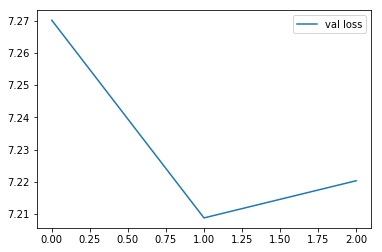

KeyboardInterrupt: 

In [10]:
import torch.utils.data
from IPython.display import clear_output



def validate_lce(network):
    network.eval()
    losses = []
    with torch.no_grad():
        for user_batch_ix,item_batch_ix, mask_batch_ix in val_loader:

            user_batch_ix = Variable(user_batch_ix).to(device)
            item_batch_ix = Variable(item_batch_ix).to(device)
            mask_batch_ix = Variable(mask_batch_ix).to(device)

            logp_seq = network(user_batch_ix, item_batch_ix)
            # compute loss
            predictions_logp = logp_seq[:, :-1]*mask_batch_ix[:, :-1,None]
            actual_next_tokens = item_batch_ix[:, 1:]

            logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
            loss = -logp_next.sum()/mask_batch_ix[:, :-1].sum()
            losses.append(loss.cpu().data.numpy())
    torch.cuda.empty_cache()
    gc.collect() 
    return np.mean(losses)

i=0


for user_batch_ix,item_batch_ix, item_mask_batch_ix in train_loader:
    network.train()
    user_batch_ix = Variable(user_batch_ix).to(device)
    item_batch_ix = Variable(item_batch_ix).to(device)
    item_mask_batch_ix = Variable(item_mask_batch_ix).to(device)
    
    logp_seq = network(user_batch_ix, item_batch_ix)
    # compute loss
    predictions_logp = logp_seq[:, :-1]*item_mask_batch_ix[:, :-1,None]
    actual_next_tokens = item_batch_ix[:, 1:]

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
    loss = -logp_next.mean()
    
    # train with backprop
    opt.zero_grad()
    loss.backward()
    
    opt.step()
    
    if (i+1)%500==0:
        val_loss = validate_lce(network)
        history.append(val_loss)
        
        clear_output(True)
        plt.plot(history,label='val loss')
        plt.legend()
        plt.show()
    i+=1


In [11]:
torch.save(network, 'network.pt')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LinearGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [133]:
test_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(test_users),torch.LongTensor(test_items),torch.FloatTensor(test_mask))),\
            batch_size=1000,shuffle=True)

def validate_mrr(network,k):
    network.eval()
    losses = []
    with torch.no_grad():
        for user_batch_ix,item_batch_ix, mask_batch_ix in test_loader:
            user_batch_ix = Variable(user_batch_ix).to(device)
            item_batch_ix = Variable(item_batch_ix).to(device)
            mask_batch_ix = Variable(mask_batch_ix).to(device)

            logp_seq = network(user_batch_ix, item_batch_ix)
            # compute loss
            predictions_logp = logp_seq[:, :-1]
            _,ind = torch.topk(predictions_logp, k,dim=-1)
            mrr = torch.zeros(predictions_logp.size())
            mrr.scatter_(-1,ind.cpu(),1/torch.range(1,k).repeat(*ind.size()[:-1],1).type(torch.FloatTensor).cpu())
            actual_next_tokens = item_batch_ix[:, 1:]
            logp_next = torch.gather(mrr.to(device)*mask_batch_ix[:, :-1,None], dim=2, index=actual_next_tokens[:,:,None])
            loss = logp_next.sum()/mask_batch_ix[:, :-1,None].sum()
            losses.append(loss.cpu().data.numpy())
    torch.cuda.empty_cache()
    gc.collect() 
    return np.mean(losses)


def validate_recall(network,k):
    network.eval()
    losses = []
    with torch.no_grad():
        for user_batch_ix,item_batch_ix, mask_batch_ix in test_loader:
            user_batch_ix = Variable(user_batch_ix).to(device)
            item_batch_ix = Variable(item_batch_ix).to(device)
            mask_batch_ix = Variable(mask_batch_ix).to(device)

            logp_seq = network(user_batch_ix, item_batch_ix)
            # compute loss
            predictions_logp = logp_seq[:, :-1]
            minus_kth_biggest_logp,_ = torch.kthvalue(-predictions_logp.cpu(), k,dim=-1,keepdim=True)
            prediicted_kth_biggest = (predictions_logp>(-minus_kth_biggest_logp.to(device)))\
                                        .type(torch.FloatTensor).to(device)
            actual_next_tokens = item_batch_ix[:, 1:]

            logp_next = torch.gather(prediicted_kth_biggest*mask_batch_ix[:, :-1,None], dim=2, index=actual_next_tokens[:,:,None])
            loss = logp_next.sum()/mask_batch_ix[:, :-1,None].sum()
            losses.append(loss.cpu().data.numpy())
    torch.cuda.empty_cache()
    gc.collect() 
    return np.mean(losses)

In [ ]:

#torch.cuda.empty_cache()
gc.collect() 
validate_recall(network,20)

In [154]:
device = torch.device("cpu")

In [ ]:
torch.cuda.empty_cache()